In [37]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import geopandas as gpd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

from itertools import product

pd.set_option('display.max_columns', None)

In [38]:
# Import the dataset
df = pd.read_csv("/content/prosperLoanData.csv")

In [39]:
category_mapping = {
    0: 'Not Available',
    1: 'Debt Consolidation',
    2: 'Home Improvement',
    3: 'Business',
    4: 'Personal Loan',
    5: 'Student Use',
    6: 'Auto',
    7: 'Other',
    8: 'Baby&Adoption',
    9: 'Boat',
    10: 'Cosmetic Procedure',
    11: 'Engagement Ring',
    12: 'Green Loans',
    13: 'Household Expenses',
    14: 'Large Purchases',
    15: 'Medical/Dental',
    16: 'Motorcycle',
    17: 'RV',
    18: 'Taxes',
    19: 'Vacation',
    20: 'Wedding Loans'
}

df['ListingCategory'] = df['ListingCategory (numeric)'].map(category_mapping)

In [40]:
# Keep potential influential predictors identified from the EDA process
# Time (Year) and Region (State) variables are also kept as predictors, but are added to the dataset later
df_filtered = df[["LoanStatus", "CreditGrade", "BorrowerRate", "ProsperScore",
                  "ListingCategory","Occupation","EmploymentStatus",
                  "IsBorrowerHomeowner", "IncomeVerifiable", "IncomeRange",
                  "LoanOriginalAmount", "Recommendations", "PercentFunded",
                  "CurrentDelinquencies" , "InquiriesLast6Months",
                  "PublicRecordsLast10Years"]]
df_filtered = df_filtered[df_filtered['LoanStatus'].isin(['Completed', 'Defaulted'])]
df_filtered['Default'] = np.where(df_filtered['LoanStatus'] == 'Completed', 0, 1) # Keep observations indicating completed cases only

# Compute the percentage of missing values in the dataset.
count = df_filtered.isnull().sum()
percent = (df_filtered.isnull().sum()/43092)
missing_data = pd.concat([count, percent], axis=1, keys=['missing_count', 'missing_percent'])
missing_data.head(100)

,missing_count,missing_percent
LoanStatus,0,0.000000
CreditGrade,20794,0.482549
BorrowerRate,0,0.000000
ProsperScore,22423,0.520352
ListingCategory,0,0.000000
Occupation,1974,0.045809
EmploymentStatus,1961,0.045507
IsBorrowerHomeowner,0,0.000000
IncomeVerifiable,0,0.000000
IncomeRange,0,0.000000


CreditGrade: The Credit rating that was assigned at the time the listing went live. Applicable for listings pre-2009 period and will only be populated for those listings;

ProsperScore: A custom risk score built using historical Prosper data. The score ranges from 1-10, with 10 being the best, or lowest risk score. Applicable for loans originated after July 2009.

In [41]:
# For convenience in model fitting, create dummy variables for different levels of categorical variables
# Creidt grade - omitted: NC
df_filtered['creditgrade_AA'] = np.where(df_filtered['CreditGrade'] == 'AA', 1, 0)
df_filtered['creditgrade_A'] = np.where(df_filtered['CreditGrade'] == 'A', 1, 0)
df_filtered['creditgrade_B'] = np.where(df_filtered['CreditGrade'] == 'B', 1, 0)
df_filtered['creditgrade_C'] = np.where(df_filtered['CreditGrade'] == 'C', 1, 0)
df_filtered['creditgrade_D'] = np.where(df_filtered['CreditGrade'] == 'D', 1, 0)
df_filtered['creditgrade_E'] = np.where(df_filtered['CreditGrade'] == 'E', 1, 0)
df_filtered['creditgrade_HR'] = np.where(df_filtered['CreditGrade'] == 'HR', 1, 0)

# Income range - omitted: Not displayed
df_filtered['no_income'] = np.where(df_filtered['IncomeRange'].isin(['$0', 'Not employed']), 1, 0)
df_filtered['income_below25k'] = np.where(df_filtered['IncomeRange'] == '$1-24,999', 1, 0)
df_filtered['income_25k_50k'] = np.where(df_filtered['IncomeRange'] == '$25,000-49,999', 1, 0)
df_filtered['income_50k_75k'] = np.where(df_filtered['IncomeRange'] == '$50,000-74,999', 1, 0)
df_filtered['income_75k_100k'] = np.where(df_filtered['IncomeRange'] == '$75,000-99,999', 1, 0)
df_filtered['income_greater100k'] = np.where(df_filtered['IncomeRange'] == '$100,000+', 1, 0)

# Homeowner - ommited: Not homeowner
df_filtered['is_homeowner'] = np.where(df_filtered['IsBorrowerHomeowner'] == 'True', 1, 0)

# Income verifiable - omitted: income is not verifiable
df_filtered['income_verifiable'] = np.where(df_filtered['IncomeVerifiable'] == 'True', 1, 0)

In [42]:
# Create a separate dummy to indicate students, as this occupation has exceptionally high default rate (findings from the EDA process)
students = ['Student - College Senior', 'Student - College Graduate Student',
                       'Student - Technical School', 'Student - College Junior',
                       'Student - Community College', 'Student - College Freshman',
                       'Student - College Sophomore']

df_filtered['is_student'] = np.where(df_filtered['Occupation'].isin(students), 1, 0)

In [43]:
# Re-categorize the employment status
def categorize_employment(status):
    if status in ['Employed', 'Full-time', 'Part-time', 'Self-employed']:
        return 'Yes'
    elif status in ['Not employed', 'Retired']:
        return 'No'
    else:
        return 'Not Available or Others'

df_filtered['Employment'] = df_filtered['EmploymentStatus'].apply(categorize_employment)

# Employment status - omitted: Not Available or Others
df_filtered['employment_yes'] = np.where(df_filtered['Employment'] == 'True', 1, 0)
df_filtered['employment_no'] = np.where(df_filtered['Employment'] == 'No', 1, 0)

In [44]:
# Re-categorize the listing category status
def categorize_listing(category):
    if category in ['Not Available']:
        return 'No'
    else:
        return 'Yes'

df_filtered['ReportedLoanPurpose'] = df_filtered['ListingCategory'].apply(categorize_listing)

# Reported purpose - omitted: No (NOT reported)
df_filtered['reported_purpose'] = np.where(df_filtered['ReportedLoanPurpose'] == 'Yes', 1, 0)

In [45]:
# Drop original, uncleaned columns
df_filtered = df_filtered.drop(columns = ['LoanStatus', 'CreditGrade', 'IsBorrowerHomeowner', 'Occupation', 'EmploymentStatus', 'Employment', 'ListingCategory', 'IncomeRange', 'IncomeVerifiable', 'ReportedLoanPurpose'])

In [46]:
# Normalize data before KNN imputation - otherwise the difference in scales of each prediction may lead to biased imputed values
scaler = MinMaxScaler()
df_filtered = pd.DataFrame(scaler.fit_transform(df_filtered), columns = df_filtered.columns)

# KNN imputation - fill in each missing value by using values of its 5 nearest neighbors (with smallest euclidean distances), uniformly weighted
imputer = KNNImputer(n_neighbors=5, weights="uniform")
X_imputed = imputer.fit_transform(df_filtered.drop(columns=['Default']))

# Convert the imputed array back to a dataframe, since the state and year dummies will be added later
X_imputed_df = pd.DataFrame(X_imputed, columns=df_filtered.drop(columns=['Default']).columns)

In [47]:
# Add dummies for fixed effects
df = df[df['LoanStatus'].isin(['Completed', 'Defaulted'])]
#df["Year"] = pd.to_datetime(df['ListingCreationDate']).dt.year
df["Year"] = pd.to_datetime(df['ListingCreationDate'], format='%Y-%m-%d %H:%M:%S', errors='coerce').dt.year

temp = df[["Year", "BorrowerState"]]
temp = temp.reset_index(drop=True)

X_imputed_df = pd.concat([X_imputed_df, temp], axis=1)
X_imputed_df["BorrowerState"].fillna("Unknown", inplace=True)

year_dummies = pd.get_dummies(X_imputed_df["Year"], prefix="Year", drop_first=True)
state_dummies = pd.get_dummies(X_imputed_df["BorrowerState"], prefix="State", drop_first=True)
X_imputed_df = pd.concat([X_imputed_df, year_dummies, state_dummies], axis=1)
X_imputed_df.drop(columns=['Year', 'BorrowerState'], inplace=True)
X_imputed_df

<ipython-input-47-014f6444b280>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Year"] = pd.to_datetime(df['ListingCreationDate'], format='%Y-%m-%d %H:%M:%S', errors='coerce').dt.year


,BorrowerRate,ProsperScore,LoanOriginalAmount,Recommendations,PercentFunded,CurrentDelinquencies,InquiriesLast6Months,PublicRecordsLast10Years,creditgrade_AA,creditgrade_A,creditgrade_B,creditgrade_C,creditgrade_D,creditgrade_E,creditgrade_HR,no_income,income_below25k,income_25k_50k,income_50k_75k,income_75k_100k,income_greater100k,is_homeowner,income_verifiable,is_student,employment_yes,employment_no,reported_purpose,Year_2006.0,Year_2007.0,Year_2008.0,Year_2009.0,Year_2010.0,Year_2011.0,Year_2012.0,Year_2013.0,State_AL,State_AR,State_AZ,State_CA,State_CO,State_CT,State_DC,State_DE,State_FL,State_GA,State_HI,State_IA,State_ID,State_IL,State_IN,State_KS,State_KY,State_LA,State_MA,State_MD,State_ME,State_MI,State_MN,State_MO,State_MS,State_MT,State_NC,State_ND,State_NE,State_NH,State_NJ,State_NM,State_NV,State_NY,State_OH,State_OK,State_OR,State_PA,State_RI,State_SC,State_SD,State_TN,State_TX,State_UT,State_Unknown,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY
0,0.317588,0.52,0.247794,0.000000,0.96463,0.024096,0.047619,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,0.552764,0.50,0.058853,0.000000,0.96463,0.012048,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,0.266332,0.60,0.000000,0.000000,0.96463,0.036145,0.047619,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
3,0.638593,0.40,0.088235,0.000000,0.96463,0.000000,0.000000,0.045455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,0.417085,0.58,0.058824,0.000000,0.96463,0.012048,0.000000,0.045455,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43087,0.582915,0.50,0.058824,0.000000,0.96463,0.216867,0.031746,0.318182,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,F

In [48]:
# Separate features and target variables
X = X_imputed_df
y = df_filtered['Default']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1006693712)

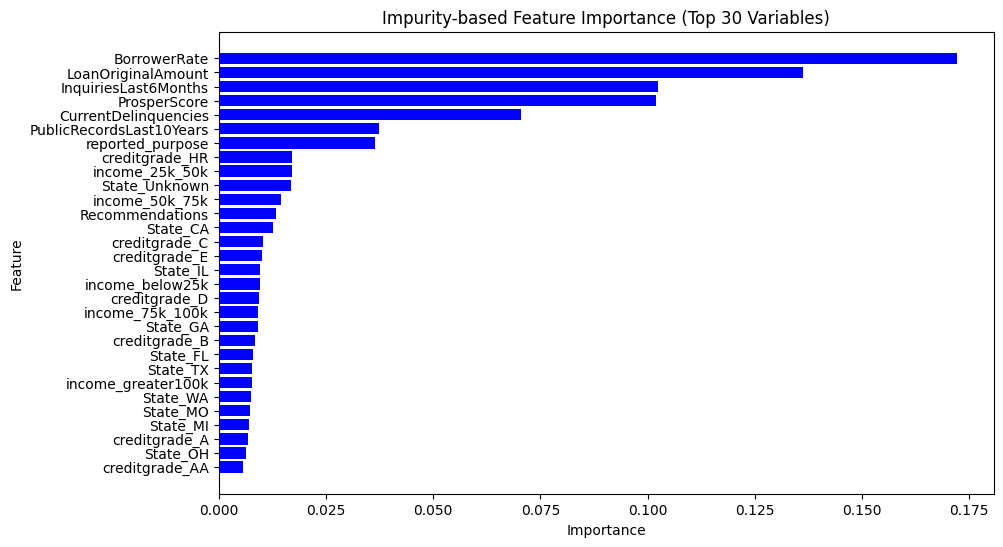

In [49]:
# Create and train the random forest model
rf_impurity = RandomForestClassifier()

# Train the model
rf_impurity.fit(X_train, y_train)

# Get feature importance scores
importance_scores_impurity = rf_impurity.feature_importances_

# Create a DataFrame to display feature importance scores
feature_importance_impurity_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance_scores_impurity})

# Sort the DataFrame by importance scores
feature_importance_impurity_df_sorted = feature_importance_impurity_df.sort_values(by='Importance', ascending=True)
# Select the top 25 most important variables
top_30_features = feature_importance_impurity_df_sorted.tail(30)

# Plot feature importance for the top 30 variables
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(top_30_features['Feature'], top_30_features['Importance'], color='blue')
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
ax.set_title('Impurity-based Feature Importance (Top 30 Variables)')

# Show the plot
plt.show()

In [ ]:
# Make predictions on the testing set
y_pred_test_rf = rf_impurity.predict(X_test)

# Calculate accuracy score on the testing set
accuracy_rf = accuracy_score(y_test, y_pred_test_rf)

print("Accuracy Score on Testing Set Using Random Forest:", accuracy_rf)

Accuracy Score on Testing Set Using Random Forest: 0.8988211268913023


In [63]:
# Get some additional variables - additional columns are needed to calculate the expected payoff
additional_df = df[(df["LoanStatus"] == "Completed") | (df["LoanStatus"] == "Defaulted")]
additional_df = additional_df.reset_index(drop=True)
additional_df = additional_df[["LoanOriginalAmount", "BorrowerRate", "LP_InterestandFees", "LP_GrossPrincipalLoss"]]
additional_df = additional_df.rename(columns={'LoanOriginalAmount': 'RealLoanOriginalAmount', 'BorrowerRate': 'RealBorrowerRate'})
additional_df

,RealLoanOriginalAmount,RealBorrowerRate,LP_InterestandFees,LP_GrossPrincipalLoss
0,9425,0.1580,1971.14,0.00
1,3001,0.2750,1185.63,0.00
2,1000,0.1325,11.65,0.00
3,4000,0.3177,311.38,3790.25
4,3000,0.2075,1061.05,0.00
...,...,...,...,...
43087,3000,0.2900,541.86,2536.11
43088,4292,0.0679,464.93,0.00
43089,2000,0.1899,83.62,0.00
43090,2500,0.2639,172.58,0.00


In [74]:
# To calculate the expected payoff using the pre-tuned random forest model with the test set, first merge payoff-related additional information to the test set
X_test = X_test.merge(additional_df, left_index=True, right_index=True)
y_test_df = pd.DataFrame(y_test, columns=["Default"])
X_test = X_test.merge(y_test_df, left_index=True, right_index=True)

# Generate variables for payoffs
X_test['payoff_TN'] = X_test["RealLoanOriginalAmount"]*(X_test["RealBorrowerRate"])
X_test['payoff_FN'] = -(X_test["LP_GrossPrincipalLoss"] + \
 (X_test["RealLoanOriginalAmount"]*(X_test["RealBorrowerRate"]) - \
  X_test["LP_InterestandFees"]))
X_test['payoff_FP'] = 0
X_test['payoff_TP'] = 0

# Restore the original X_test dataset that used for pre-tuned random forest model
columns_to_remove = ["RealLoanOriginalAmount", "RealBorrowerRate", "LP_InterestandFees",
                     "LP_GrossPrincipalLoss", "Default", "payoff_TN", "payoff_FN",
                     "payoff_FP", "payoff_TP"]
X_test_original = X_test.drop(columns=columns_to_remove)

In [72]:
# calculate the expected payoff returned by the pre-tuned random forest model using the test set
rf_impurity_predictions = rf_impurity.predict(X_test_original)
rf_impurity_TP = (rf_impurity_predictions == 1) & (y_test_df["Default"] == 1)
rf_impurity_TN = (rf_impurity_predictions == 0) & (y_test_df["Default"] == 0)
rf_impurity_FP = (rf_impurity_predictions == 1) & (y_test_df["Default"] == 0)
rf_impurity_FN = (rf_impurity_predictions == 0) & (y_test_df["Default"] == 1)
rf_impurity_expected_payoff = (np.sum(X_test['payoff_TP'][rf_impurity_TP]) + \
                   np.sum(X_test['payoff_TN'][rf_impurity_TN]) + \
                   np.sum(X_test['payoff_FP'][rf_impurity_FP]) + \
                   np.sum(X_test['payoff_FN'][rf_impurity_FN])) / len(rf_impurity_predictions)
print("Expected payoff on the test set using the pre-tuned random forest model:", rf_impurity_expected_payoff)

Expected payoff on the test set using the pre-tuned random forest model: 491.84790574584616


Without model tuning, the random forest algorithm achieves a test accuracy of 0.8988, yielding an expected payoff of $491.85.

In [51]:
# Now, let's tune the random forest algorithm by grid searching the optimized hyperparameters that can bring maximized expected payoff
# To address any potential overfitting concern, keep features with top 30 importance for continue use as predictors prior to model tuning
kept_rf_features = top_30_features['Feature'].tolist()
X_rf = X[kept_rf_features]
# Prepare the dataset for profit maximazation
temp_rf = df_filtered[["Default"]]
temp_rf_combined = pd.merge(X_rf, temp_rf, left_index=True, right_index=True)
# Merge the additional variables extracted earlier to maximize the expected payoff
temp_rf_combined = pd.merge(temp_rf_combined, additional_df, left_index=True, right_index=True)
temp_rf_combined

,creditgrade_AA,State_OH,creditgrade_A,State_MI,State_MO,State_WA,income_greater100k,State_TX,State_FL,creditgrade_B,State_GA,income_75k_100k,creditgrade_D,income_below25k,State_IL,creditgrade_E,creditgrade_C,State_CA,Recommendations,income_50k_75k,State_Unknown,income_25k_50k,creditgrade_HR,reported_purpose,PublicRecordsLast10Years,CurrentDelinquencies,ProsperScore,InquiriesLast6Months,LoanOriginalAmount,BorrowerRate,Default,RealLoanOriginalAmount,RealBorrowerRate,LP_InterestandFees,LP_GrossPrincipalLoss
0,0.0,False,0.0,False,False,False,0.0,False,False,0.0,False,0.0,0.0,0.0,False,0.0,1.0,False,0.000000,0.0,False,1.0,0.0,0.0,0.000000,0.024096,0.52,0.047619,0.247794,0.317588,0.0,9425,0.1580,1971.14,0.00
1,0.0,False,0.0,False,False,False,0.0,False,False,0.0,True,0.0,0.0,0.0,False,0.0,0.0,False,0.000000,0.0,False,0.0,1.0,0.0,0.000000,0.012048,0.50,0.000000,0.058853,0.552764,0.0,3001,0.2750,1185.63,0.00
2,0.0,False,0.0,False,False,False,0.0,False,False,0.0,False,0.0,0.0,1.0,False,0.0,1.0,False,0.000000,0.0,True,0.0,0.0,0.0,0.000000,0.036145,0.60,0.047619,0.000000,0.266332,0.0,1000,0.1325,11.65,0.00
3,0.0,False,0.0,False,False,False,0.0,False,True,0.0,False,0.0,0.0,0.0,False,0.0,0.0,False,0.000000,1.0,False,0.0,0.0,1.0,0.045455,0.000000,0.40,0.000000,0.088235,0.638593,1.0,4000,0.3177,311.38,3790.25
4,0.0,False,0.0,True,False,False,0.0,False,False,0.0,False,0.0,1.0,0.0,False,0.0,0.0,False,0.000000,0.0,False,1.0,0.0,0.0,0.045455,0.012048,0.58,0.000000,0.058824,0.417085,0.0,3000,0.2075,1061.05,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43087,0.0,False,0.0,False,False,False,0.0,False,False,0.0,False,0.0,0.0,0.0,False,1.0,0.0,True,0.000000,0.0,False,0.0,0.0,0.0,0.318182,0.216867,0.50,0.031746,0.058824,0.582915,1.0,3000,0.2900,541.86,2536.11
43088,1.0,False,0.0,False,False,True,1.0,False,False,0.0,False,0.0,0.0,0.0,False,0.0,0.0,False,0.051282,0.0,False,0.0,0.0,1.0,0.000000,0.000000,0.88,0.015873,0.096824,0.136482,0.0,4292,0.0679,464.93,0.00
43089,0.0,False,0.0,False,False,False,0.0,False,False,0.0,False,0.0,0.0,0.0,False,0.0,0.0,False,0.000000,0.0,False,1.0,0.0,1.0,0.000000,0.000000,0.50,0.000000,0.029412,0.381709,0.0,2000,0.1899,83.62,0.00
43090,0.0,False,0.0,False,False,False,0.0,False,True,0.0,False,0.0,0.0,0.0,False,0.0,0.0,False,0.000000,1.0,False,0.0,0.0,1.0,0.000000,0.000000,0.20,0.031746,0.044118,0.530452,0.0,2500,0.2639,172.58,0.00


In [52]:
# Generate variables for payoffs
temp_rf_combined['payoff_TN'] = temp_rf_combined["RealLoanOriginalAmount"]*(temp_rf_combined["RealBorrowerRate"])
temp_rf_combined['payoff_FN'] = -(temp_rf_combined["LP_GrossPrincipalLoss"] + \
 (temp_rf_combined["RealLoanOriginalAmount"]*(temp_rf_combined["RealBorrowerRate"]) - \
  temp_rf_combined["LP_InterestandFees"]))
temp_rf_combined['payoff_FP'] = 0
temp_rf_combined['payoff_TP'] = 0
temp_rf_combined

,creditgrade_AA,State_OH,creditgrade_A,State_MI,State_MO,State_WA,income_greater100k,State_TX,State_FL,creditgrade_B,State_GA,income_75k_100k,creditgrade_D,income_below25k,State_IL,creditgrade_E,creditgrade_C,State_CA,Recommendations,income_50k_75k,State_Unknown,income_25k_50k,creditgrade_HR,reported_purpose,PublicRecordsLast10Years,CurrentDelinquencies,ProsperScore,InquiriesLast6Months,LoanOriginalAmount,BorrowerRate,Default,RealLoanOriginalAmount,RealBorrowerRate,LP_InterestandFees,LP_GrossPrincipalLoss,payoff_TN,payoff_FN,payoff_FP,payoff_TP
0,0.0,False,0.0,False,False,False,0.0,False,False,0.0,False,0.0,0.0,0.0,False,0.0,1.0,False,0.000000,0.0,False,1.0,0.0,0.0,0.000000,0.024096,0.52,0.047619,0.247794,0.317588,0.0,9425,0.1580,1971.14,0.00,1489.1500,481.9900,0,0
1,0.0,False,0.0,False,False,False,0.0,False,False,0.0,True,0.0,0.0,0.0,False,0.0,0.0,False,0.000000,0.0,False,0.0,1.0,0.0,0.000000,0.012048,0.50,0.000000,0.058853,0.552764,0.0,3001,0.2750,1185.63,0.00,825.2750,360.3550,0,0
2,0.0,False,0.0,False,False,False,0.0,False,False,0.0,False,0.0,0.0,1.0,False,0.0,1.0,False,0.000000,0.0,True,0.0,0.0,0.0,0.000000,0.036145,0.60,0.047619,0.000000,0.266332,0.0,1000,0.1325,11.65,0.00,132.5000,-120.8500,0,0
3,0.0,False,0.0,False,False,False,0.0,False,True,0.0,False,0.0,0.0,0.0,False,0.0,0.0,False,0.000000,1.0,False,0.0,0.0,1.0,0.045455,0.000000,0.40,0.000000,0.088235,0.638593,1.0,4000,0.3177,311.38,3790.25,1270.8000,-4749.6700,0,0
4,0.0,False,0.0,True,False,False,0.0,False,False,0.0,False,0.0,1.0,0.0,False,0.0,0.0,False,0.000000,0.0,False,1.0,0.0,0.0,0.045455,0.012048,0.58,0.000000,0.058824,0.417085,0.0,3000,0.2075,1061.05,0.00,622.5000,438.5500,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43087,0.0,False,0.0,False,False,False,0.0,False,False,0.0,False,0.0,0.0,0.0,False,1.0,0.0,True,0.000000,0.0,False,0.0,0.0,0.0,0.318182,0.216867,0.50,0.031746,0.058824,0.582915,1.0,3000,0.2900,541.86,2536.11,870.0000,-2864.2500,0,0
43088,1.0,False,0.0,False,False,True,1.0,False,False,0.0,False,0.0,0.0,0.0,False,0.0,0.0,False,0.051282,0.0,False,0.0,0.0,1.0,0.000000,0.000000,0.88,0.015873,0.096824,0.136482,0.0,4292,0.0679,464.93,0.00,291.4268,173.5032,0,0
43089,0.0,False,0.0,False,False,False,0.0,False,False,0.0,False,0.0,0.0,0.0,False,0.0,0.0,False,0.000000,0.0,False,1.0,0.0,1.0,0.000000,0.000000,0.50,0.000000,0.029412,0.381709,0.0,2000,0.1899,83.62,0.00,379.8000,-296.1800,0,0
43090,0.0,False,0.0,False,False,False,0.0,False,True,0.0,False,0.0,0.0,0.0,False,0.0,0.0,False,0.000000,1.0,False,0.0,0.0,1.0,0.000000,0.000000,0.20,0.031746,0.044118,0.530452,0.0,2500,0.2639,172.58,0.00,659.7500,-487.1700,0,0


In [ ]:
X_rf_cleaned = temp_rf_combined.drop(columns=["Default"])
y_rf_cleaned = temp_rf_combined[['Default']]

# Split the data into training and testing sets
X_rf_train, X_rf_test, y_rf_train, y_rf_test = train_test_split(X_rf_cleaned, y_rf_cleaned, test_size=0.25, random_state=1006693712)

In [ ]:
# Hyperparameter choices are set based on existing literatures, which are discussed in the paper
param_choices = {
    'n_estimators': [64, 96, 128],
    'max_depth': [3, 5, 7],
    'min_samples_split': [100, 300, 500]
}

# Define a custom scoring function to maximize expected payoff
# For each observation, identify its payoff according to its prediction result - e.g. if an individual is predicted to default (predicted default = 1) and indeed defaulted (actual default = 1), then we have the true positive payoff for this particular individual
# The payoff for each individual is calculated in the same way as described above
# Sum the payoff for all, TP, TN, FP, FN, therefore obtaining the total payoff
# Divide the total payoff by the total number of prediction to get the expected payoff per individual
def custom_scorer(estimator, X, y):
    predictions = estimator.predict(X)
    TP = (predictions == 1) & (y["Default"] == 1)
    TN = (predictions == 0) & (y["Default"] == 0)
    FP = (predictions == 1) & (y["Default"] == 0)
    FN = (predictions == 0) & (y["Default"] == 1)
    expected_payoff = (np.sum(X['payoff_TP'][TP]) + \
             np.sum(X['payoff_TN'][TN]) + \
             np.sum(X['payoff_FP'][FP]) + \
             np.sum(X['payoff_FN'][FN])) / len(predictions)
    return expected_payoff

# First define an arbitrary optimal payoff start point
optimal_payoff = -np.inf
optimal_hyperparameters = None


# Iterate over all combinations of hyperparameters
for params in product(*param_choices.values()):
    # Combine parameter names with parameter values
    param_dict = dict(zip(param_choices.keys(), params))

    # Initialize Random Forest Classifier with current hyperparameters, then use grid search to tune the classifier
    rf = RandomForestClassifier(**param_dict)
    grid_search = GridSearchCV(rf, param_choices, scoring=custom_scorer, cv=5)
    grid_search.fit(X_rf_train, y_rf_train)

    # Hold the best classifier found by the grid search process
    current_best_estimator = grid_search.best_estimator_

    # Calculate the current payoff using the best estimator
    # To optimize the model with generalization power on new data, the expected payoff is calculated and maximized using the test set
    current_payoff = custom_scorer(current_best_estimator, X_rf_test, y_rf_test)

    # Update optimal hyperparameters if the current hyperparameters yield a higher payoff
    if current_payoff > optimal_payoff:
        optimal_payoff = current_payoff
        optimal_hyperparameters = param_dict

print("Optimal Payoff:", optimal_payoff)
print("Optimal Hyperparameters:", optimal_hyperparameters)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed whe

Optimal Payoff: 973.3346989417989
Optimal Hyperparameters: {'n_estimators': 96, 'max_depth': 3, 'min_samples_split': 100}


In [ ]:
# Train the final selected model with optimal hyperparameters
selected_rf = RandomForestClassifier(**optimal_hyperparameters)
selected_rf.fit(X_rf_train, y_rf_train)

# Predict on the test set using the final model
selected_test_predictions = selected_rf.predict(X_rf_test)

# Calculate the test accuracy
selected_test_accuracy = accuracy_score(y_rf_test, selected_test_predictions)

print("Test Accuracy of the Selected Model:", selected_test_accuracy)

<ipython-input-114-05d5caece6dc>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  selected_rf.fit(X_rf_train, y_rf_train)


Test Accuracy of the Selected Model: 0.9969367864104706


As shown in the grid search result, we have the optimal number of trees to be 96, the maximum depth of a tree to be 3, and the minimum samples to split at a node to be 100 in our forest.

Additionally, the prediction performance is significantly enhanced: the accuracy of the tuned random forest model on the test set reaches to 0.997, with an expected payoff of $973.33.